<h1 align="center"> The Battle of Neighborhoods <h1/>

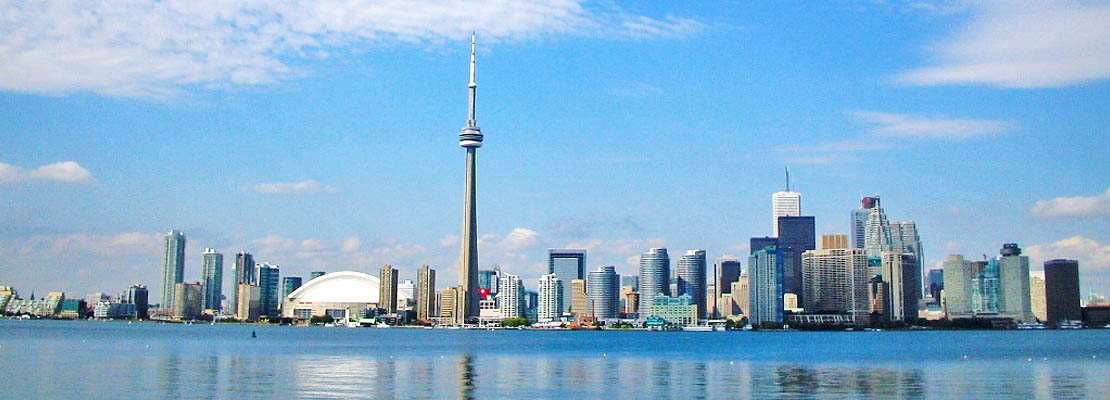

To complete this module, I will take the idea suggested by the course instructor, and will work on a project that will help small entrepreneurs to find the best location in Toronto city to open their business. 

### 1- Business problem
Toronto is the most populous city in Canada, and also the largest one. Being a centre of business, finance, arts, and culture, Toronto has become one of the most multicultural cities in the world. Not to mention that the city is the most populous and largest in Canada. 
When you have that much space available, how do you know where to open a new business? My goal with this project is to help a possible stakeholder to choose the best place to open his restaurant, considering the competition and population in each area. 


### 2- Target audience 
Business entrepreneur that wants to open a new restaurant in Toronto.<br>
Enthusiasts in data science interested in learning about working with foursquare, folium, k-means clustering, pandas,numpy, etc. <br>
Tourists or residents looking for an area with a lot of restaurants


### 3- The data
First, we need data about the city of Toronto, its neighborhoods and boroughs. Wikipedia have all the information available at: 
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M <br>
BeautifulSoup will be used for scrapping.

<br>

Then, we will need information about restaurants in each area. Foursquare API will be used to extract the venues, addresses and ratings. Foursquare API can be found at https://developer.foursquare.com/docs/api-reference/venues/explore/

<br>

In order to explore the data visually, I will be using Folium. Folium is a python library that can create interactive maps using coordinate data.
Coordinates will be obtained via Geocode(from geopy).

<br>

If necessary, other demographic data could be used for further tests. The data is available at: https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods


Let's start by installing and importing some of the modules we're gonna need

In [63]:
!pip install bs4
!pip install geopy
!pip install folium

from bs4 import BeautifulSoup
import folium 
from geopy.geocoders import Nominatim
import requests
import pandas as pd
from config import *
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

Define the first dataframe we are going to use. Source is wikipedia and BeautifulSoup is used for scrapping.

In [64]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data  = requests.get(url).text

In [65]:
soup = BeautifulSoup(data,  "html.parser")

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [66]:
import pandas as pd

df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [67]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


Now let's merge the location for each neighbourhood. I used the CSV file provided by Coursera, but this information can also be extracted using geolocator.

In [68]:
csv = pd.read_csv('Geospatial_Coordinates.csv')
df2 = pd.DataFrame(csv)

df2.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
df = pd.merge(df,df2,on='PostalCode')  
df.head(5)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [69]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


Here I create the function that will extract the information from Foursquare. Sensitive data such as client secret have been hidden for security purposes in a separate file. 

In [70]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define distance radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
                
        # store everything in a json file
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [71]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                latitudes=df['Latitude'],
                                longitudes=df['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [72]:
toronto_venues.shape

(2153, 7)

Storing the venues data along with the neighborhood data.

In [73]:
toronto_restaurants = toronto_venues[toronto_venues['Venue Category'].str.contains("Restaurant")]
toronto_restaurants

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
5,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
11,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
29,"Regent Park, Harbourfront",43.654260,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
30,"Regent Park, Harbourfront",43.654260,-79.360636,El Catrin,43.650601,-79.358920,Mexican Restaurant
...,...,...,...,...,...,...,...
2115,Church and Wellesley,43.665860,-79.383160,A&W,43.666415,-79.378235,Fast Food Restaurant
2120,Church and Wellesley,43.665860,-79.383160,McDonald's,43.668854,-79.385962,Fast Food Restaurant
2127,Enclave of M4L,43.662744,-79.321558,Chick-n-Joy,43.665181,-79.321403,Fast Food Restaurant
2129,Enclave of M4L,43.662744,-79.321558,The Green Wood,43.664728,-79.324117,Restaurant


In [74]:
print('{} uniques restaurants categories were found.'.format(len(toronto_restaurants['Venue Category'].unique())))


51 uniques restaurants categories were found.


So now we have a dataframe with all these restaurants in Toronto with 48 unique categories. 

For data analysis we need to convert the categorial values in "Venue Category" to numerical values. In order to do so, I am going to use the one hot encoding method.

In [75]:
to_onehot = pd.get_dummies(toronto_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhood'] = toronto_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(483, 52)


,Neighborhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,...,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
29,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Then, I'm going to group rows by neighborhood and take the mean of the frequency of occurrence of each category.

In [76]:
to_grouped = to_onehot.groupby(["Neighborhood"]).mean().reset_index() 

print(to_grouped.shape)
to_grouped.head()

(64, 52)


,Neighborhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,...,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Agincourt,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.333333,0.000000,0.333333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,Bayview Village,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,"Bedford Park, Lawrence Manor East",0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,...,0.090909,0.000000,0.090909,0.0,0.090909,0.0,0.0,0.0,0.000000,0.0
4,Berczy Park,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,...,0.153846,0.153846,0.000000,0.0,0.076923,0.0,0.0,0.0,0.076923,0.0


At this point, the entrepreneur that wants to open his restaurant must have in mind the cuisine type. If not, the dataset above may help. This project will proceed using Chinese Restaurants. Let's group them.

In [77]:
chinese_restaurants = to_grouped[["Neighborhood","Chinese Restaurant"]]
print(chinese_restaurants.shape)
chinese_restaurants.head()

(64, 2)


,Neighborhood,Chinese Restaurant
0,Agincourt,0.0
1,"Bathurst Manor, Wilson Heights, Downsview North",0.0
2,Bayview Village,0.5
3,"Bedford Park, Lawrence Manor East",0.0
4,Berczy Park,0.0


Now for clustering we are going to use k-means. First, we need to find the best K value possible. To do so, the Elbow Point method will be used.

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return_n_iter=True)


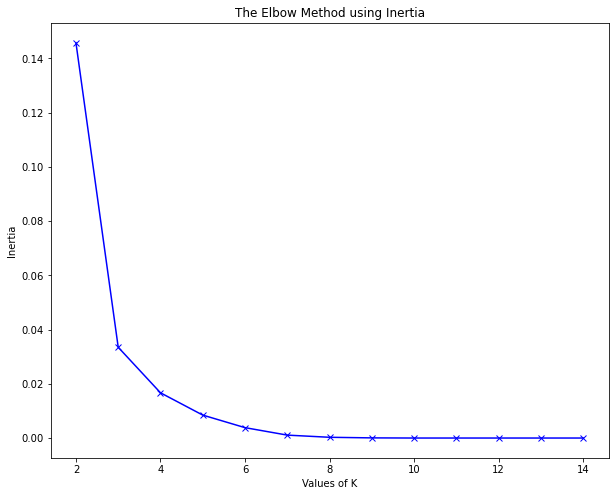

In [78]:
chinese_means = chinese_restaurants.drop(['Neighborhood'], axis=1)

plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,15)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(chinese_means)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

According to the graph, the optimum K value is 4. Therefore, we will have 4 clusters.

In [79]:
kclusters = 4

chinese_means = chinese_restaurants.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chinese_means)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10]) #check cluster labels generated for first ten rows 
print(np.unique(kmeans.labels_)) #check unique values for kmeans 

[1 1 2 1 1 1 1 1 1 1]
[0 1 2 3]


Now we will create a dataframe that includes the Neighborhood, the restaurants, the cluster labels, venues and all locations.

In [80]:
final_df = chinese_restaurants.copy()
final_df["Cluster Labels"] = kmeans.labels_

In [81]:
final_df = final_df.join(toronto_restaurants.set_index('Neighborhood'), on='Neighborhood')

print(final_df.shape)
final_df.head()

(483, 9)


,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,1,43.794200,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
1,"Bathurst Manor, Wilson Heights, Downsview North",0.0,1,43.754328,-79.442259,Bagel Plus,43.755395,-79.440686,Restaurant
1,"Bathurst Manor, Wilson Heights, Downsview North",0.0,1,43.754328,-79.442259,Orly Restaurant & Grill,43.754493,-79.443507,Middle Eastern Restaurant
1,"Bathurst Manor, Wilson Heights, Downsview North",0.0,1,43.754328,-79.442259,Wakame Sushi,43.755382,-79.440945,Sushi Restaurant
2,Bayview Village,0.5,2,43.786947,-79.385975,Sun Star Chinese Cuisine 翠景小炒,43.787914,-79.381234,Chinese Restaurant


Now let's visualize these clusters on a folium map. 

In [82]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# set color scheme for the clusters

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_df['Neighborhood Latitude'], final_df['Neighborhood Longitude'], final_df['Neighborhood'], final_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

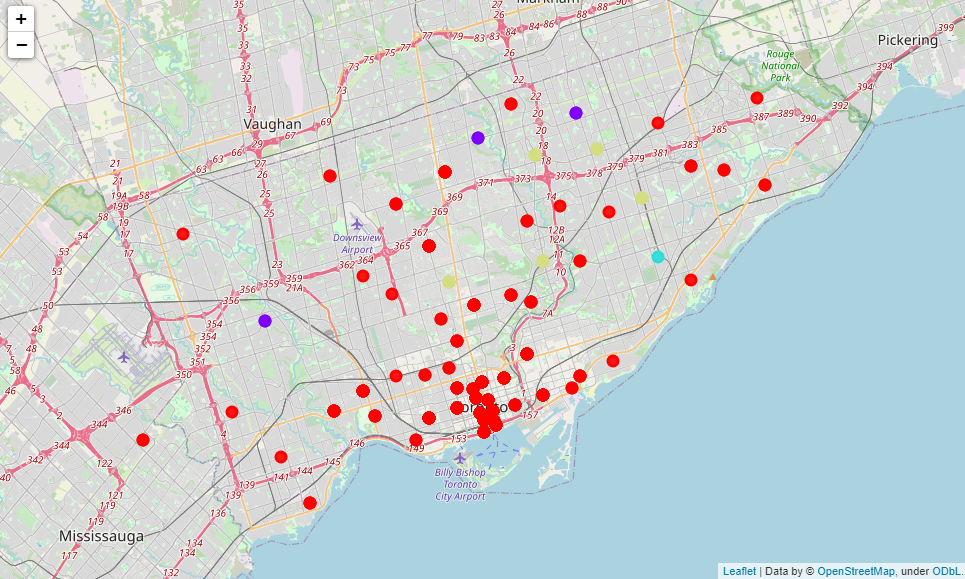

Github won't show the map visualization, so here is a print screen from my local repository. 
This map is showing us different clusters that have a similar mean frequency of Chinese restaurants.

Now let's check how many neighborhoods are in each cluster and plot into a graph

In [83]:
chinese_restaurants["Cluster Labels"] = kmeans.labels_
chinese_restaurants['Cluster Labels'].value_counts()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1    55
3     4
0     3
2     2
Name: Cluster Labels, dtype: int64

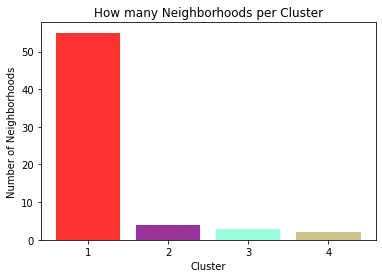

In [94]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = chinese_restaurants['Cluster Labels'].value_counts().to_frame()
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Number of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

Now, to conclude our analysis, lets see how many chinese restaurants are in each cluster. 

In [85]:
df_new = df[['Borough', 'Neighborhood']]

cluster0 = final_df.loc[final_df['Cluster Labels'] == 0]
df_cluster0 = pd.merge(df_new, cluster0, on='Neighborhood')

cluster1 = final_df.loc[final_df['Cluster Labels'] == 1]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')

cluster2 = final_df.loc[final_df['Cluster Labels'] == 2]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')

cluster3 = final_df.loc[final_df['Cluster Labels'] == 3]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')

Text(0.5, 1.0, 'Average number of Chinese Restaurants per Cluster')

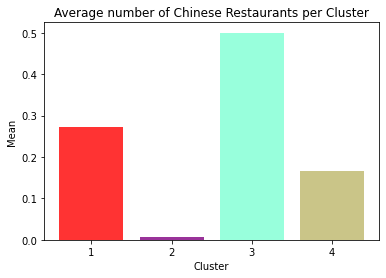

In [92]:

clusters_mean = [df_cluster0['Chinese Restaurant'].mean(),df_cluster1['Chinese Restaurant'].mean(),df_cluster2['Chinese Restaurant'].mean(),
                df_cluster3['Chinese Restaurant'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Chinese Restaurants per Cluster')

## Conclusion

After cleaning, work with the data available and plot these last graphics, we are done with our job. We had a business problem, and it was addressed in a way that it was similar to how a real data scientist would do, and can answer properly the best location for a Chinese Restaurant in Toronto.

Between these four clusters, the only one that have no Chinese Restaurant is the purple one. This means that our client would have no competition. Besides, this cluster is the second one that covers more neighborhoods, only losing for red that was disregarded by the large concentration of existing restaurants and unspecified area covered.

This methodology can be used to find best place for other purposes such as apartment rent, open any kind of business, release a product, etc. 


